In [36]:
import csv
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
#from wordcloud import WordCloud
import tempfile

import preprocessor as p


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import RSLPStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools


%matplotlib inline

# Métodos de Pré Processamento 

In [2]:
def remove_stopwords(text):
     # remove punctuation
    chars = ['…','.', '/', ''', ''', '?', '!', '$', '%', '^', '&',
             '*', '(', ')', ' - ', '_', '+', '=', '@', ':',
             '\\', ',',
             ';', '~', '`', '<', '>', '|', '[', ']', '{', '}',
             '–', '“',
             '»', '«', '°', '’', '1', '2',
             '3', '4', '5', '6', '7', '8', '9', '0', 'https', 'http']
    for c in chars:
        text= text.replace(c,' ').lower()
    text = text.split()
    import nltk
    # Caso seja preciso mudar o idioma, basta inserir o idioma desejado no parâmetro.
    stopwords = nltk.corpus.stopwords.words('portuguese')
    content = [w for w in text if w.lower().strip() not in stopwords]

    return content

In [3]:
def tokenize(text):
    tokens = word_tokenize(text)
    porter = RSLPStemmer()
    tokens = [porter.stem(t) for t in tokens]
    tokens = [
                t for t in tokens
                    if len(t)> 2 and not t.isdigit()
    ]
    return tokens

In [4]:
def remove_emoji(text):
#    print(text)
   d=[]
   d = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
   d = d.sub(r'', text)
   return d

In [5]:
def remove_url(text):
   b=[]
   b = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
   return b

In [6]:
def remove_mentions(text):
   c=[]
   c = re.sub(r"(?:\@|https?\://)\S+", "", text)
   c = re.sub('[rt]', "", c)
   return c

In [7]:
def remove_hashtag(text):
    words = text.split()
    for i in words:
        if i.startswith('#'):
            words.remove(i)
    text = ''.join(text)
    return text

In [8]:
def aplica_steaming(text):
    stemmer = nltk.steam.RLSPStemmer()
    tweetsStemming = []
    for doc in text:
        comStemming = [srt(stemmer.steam(d)) for d in text.splip()]
        tweetsStemming.append(comStemming)

In [25]:
dataset = csv.reader(open('data/desbalanceado-dataset.csv', 'r', encoding='utf-8'))
list_docs = []
list_labels = []

for row in dataset:
    list_docs.append(row[1])
    list_labels.append(row[2])

In [26]:
print(list_docs[0], list_labels[0])

Hoje é aniversário da @LarissaSiriani :) parabéns, Lari e toda a felicidade e as boas energias pra você https://t.co/ZOe5qNHc6I 1


In [27]:
count_0=0
count_1=0

list_0=[]
list_1=[]

documents = []
labels    = []

doc = []
with open('data/desbalanceado-dataset.csv','r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter =',')
    for row in reader:
        if int(row[2])==1:
            count_1+=1
            list_1.append(row[0])
        else:
            count_0+=1
            list_0.append(row[0])
            
        documents.append(row[1])
        labels.append(row[2])

In [28]:
clean_documents = []
for doc in documents:
    #usando as funcões da tweetpreprocess
    tweetsLimpos = p.clean(doc)
    tweetsPreProcessados = remove_stopwords(tweetsLimpos)
    #tokenizado = tokenize(tweetsPreProcessados)
    document = ' '.join(tweetsPreProcessados)
    clean_documents.append(document)

    
tokenizado_documents = []
for doc in clean_documents:
    tokenizado = tokenize(doc)
    document = ' '.join(tokenizado)
    tokenizado_documents.append(document)

In [49]:
print(tokenizado_documents)

['obrig dimm import pergunt', 'cas algu aind saib par dar conselh pra gent conheç internet elic', 'tou com pudim', 'tnt temp solt acontec agr', 'fal gal saiu videi nov canal gost inscreva-s obg gameplay obg', 'nad', 'sej gul esper final', 'fiq feliz escolh dire gay pro film', 'enquant ajud conhec min lind mig obrig ️️️ senã vagabund fod', 'smil sub hashtag vam ajud', 'hoj good vib pfvr mig colabor cmg pra permanec assim', 'hoj', 'ind', 'val reconhec man apreci verdad', 'obrig nen', 'dia faz histór cont', 'fal', 'obrig', 'etern ora', 'lind vou pra salv prox', 'temp verb err', 'sabad est toc apart botec amig situ etap quadr bor tom cerv gel', 'amig snap aguent', 'enfim dia menos descans vou curt show bbng hoj part pra', 'encontr felic pequen cois tempestad irá arruin complet dia', 'força-taref liber muit inform pergunt prov boa pesquis', 'parab', 'ano pass receb apresent vam ver ano fic promess', 'macet element atribut pat', 'olá quer sim hahah', 'dificuldad pra acord ced coloqu despert 

# Matrix de Confusão

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Classificada')

# DESCRIÇÃO DA BASE DE DADOS

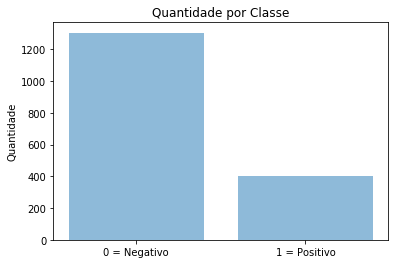

In [41]:
objects = ('0 = Negativo', '1 = Positivo')
y_pos = np.arange(len(objects))
performance = [count_0, count_1]

plt.bar(y_pos, performance, align='center',alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Quantidade')
plt.title('Quantidade por Classe')

plt.show()

# TF-IDF

In [31]:
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(tokenizado_documents)
y = labels

# MÉTRICAS: ACURÁCIA, F1, RECALL, PRECISION

In [44]:
def train(classifier, X, y, class_names):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=81)
    
    ##TREINANDO MEU ALGORITMO
    classifier.fit(X_train, y_train)
    
    ##Predicoes para medição da Acurácia
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    print("Acurracia: %s" % classifier.score(X_test,y_test))
    print("F1: %s" % str(f1_score(y_test, y_pred, average=None )))
    print("Recall: %s"% str(recall_score(y_test, y_pred, average=None)))
    print("Precision: %s" % str(precision_score(y_test, y_pred, average=None)))
    
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Matriz de Confusao')
    
    plt.show()
    
    return classifier

# MultinomialNB

Acurracia: 0.7953216374269005
F1: [0.87 0.55]
Recall: [0.92 0.46]
Precision: [0.82 0.68]
Confusion matrix, without normalization
[[115  10]
 [ 25  21]]


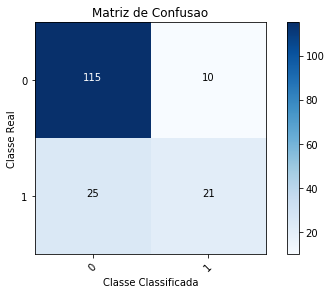

MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True)

In [45]:
train(MultinomialNB(alpha=0.05), X, y, [0,1])

# Suport Vector Machine 

Acurracia: 0.7777777777777778
F1: [0.87 0.32]
Recall: [0.99 0.2 ]
Precision: [0.77 0.9 ]
Confusion matrix, without normalization
[[124   1]
 [ 37   9]]


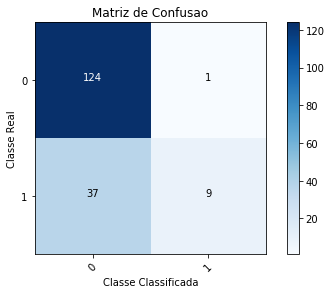

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [46]:
train(svm.SVC(kernel='linear', C=1.0), X,y, [0,1])

# SGDClassifier

c:\users\jarde\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Acurracia: 0.7777777777777778
F1: [0.86 0.46]
Recall: [0.94 0.35]
Precision: [0.8  0.67]
Confusion matrix, without normalization
[[117   8]
 [ 30  16]]


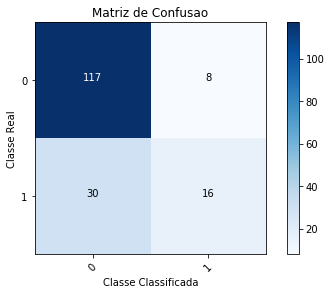

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [47]:
train(SGDClassifier(alpha=0.0001), X,y, ['0','1'])

# CrossValidation

In [43]:
from multiscorer import MultiScorer
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


models = [MultinomialNB(alpha=0.05), svm.SVC(), SGDClassifier(alpha=0.0001)]
names = ['MultinomialNB', 'SVM', 'SGDC']

scorer = MultiScorer({
    'Accuracy' : (accuracy_score, {}),
    'Precision' : (precision_score, {'pos_label': 3, 'average':'macro'}),
    'Recall' : (recall_score, {'pos_label': 3, 'average':'macro'})
})

for model, name in zip(models, names):
    print (name)
    start = time.time()

    cross_val_score(model, X, y,scoring=scorer, cv=5)
    results = scorer.get_results()

    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        print('%s : %f' % (metric_name, average_score))

    print ('time :', time.time() - start, '\n\n')
    
#    for metric_name in results.keys():
#        average_score = np.average(results[metric_name])
#        print('%s : %f' % (metric_name, average_score))
#    
#    print ('time :', time.time() - start, '\n\n')

#scores_MultinomialNB_classifier = cross_validate(MultinomialNB_classifier, X, y, cv=cv, scoring=scoring)
#print (scores.keys(), 
#       scores_MultinomialNB_classifier)

#scores_SVM_classifier = cross_validate(SVM_classifier, X, y, cv=cv, scoring=scoring)
#print (scores.keys(),
#       scores_SVM_classifier)

#scores_SGDC_Classifier = cross_val_score(SGDC_Classifier, X, y, cv=cv, score=scoring)
#print (scores_SGDC_Classifier)

NameError: name 'X_test' is not defined